Appliance Energy Usage: A Multivariate Time Series Forecasting Example

Experimental data used to create regression models of appliances energy use in a low energy building. Data Set Information:

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters). Original source of the dataset:


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('energydata_complete.csv',index_col='date',
                infer_datetime_format=True)
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9           19735 

In [4]:
#predict the next 24 hours
df = df.loc['2016-05-01':] #grap the May
df = df.round(2) #round to decrease noise
len(df)

3853

In [5]:
# How many rows per day? We know its every 10 min 24*60/10


test_days = 2
test_ind = test_days*144
print(test_ind)
train = df.iloc[:-test_ind]
test = df.iloc[-test_ind:]


288


In [6]:
print(train.tail())
print(test.head())

                     Appliances  lights    T1  ...  Tdewpoint    rv1    rv2
date                                           ...                         
2016-05-25 17:20:00         120       0  24.5  ...       6.43  33.46  33.46
2016-05-25 17:30:00         190       0  24.5  ...       6.75   0.43   0.43
2016-05-25 17:40:00         160       0  24.5  ...       7.07  16.67  16.67
2016-05-25 17:50:00          90       0  24.5  ...       7.38  39.36  39.36
2016-05-25 18:00:00         100       0  24.5  ...       7.70  38.63  38.63

[5 rows x 28 columns]
                     Appliances  lights     T1  ...  Tdewpoint    rv1    rv2
date                                            ...                         
2016-05-25 18:10:00         170       0  24.50  ...       7.62  38.14  38.14
2016-05-25 18:20:00         310       0  24.50  ...       7.53  31.16  31.16
2016-05-25 18:30:00         120       0  24.50  ...       7.45   4.40   4.40
2016-05-25 18:40:00         120       0  24.50  ...       7.

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [9]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [10]:
length = 144 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [11]:
print(len(scaled_train),len(generator) )

3565 3421


In [12]:
X,y = generator[0]

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [14]:
model = Sequential()

# Simple RNN layer
model.add(LSTM(100,input_shape=(length,scaled_train.shape[1])))

# Final Prediction (one neuron per feature)
model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               51600     
_________________________________________________________________
dense (Dense)                (None, 28)                2828      
Total params: 54,428
Trainable params: 54,428
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=1)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                           length=length, batch_size=batch_size)

In [16]:
model.fit(generator,epochs=10,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/10
3421/3421 [==============================] - 38s 9ms/step - loss: 0.0115 - val_loss: 0.0114
Epoch 2/10
3421/3421 [==============================] - 33s 10ms/step - loss: 0.0079 - val_loss: 0.0084
Epoch 3/10
3421/3421 [==============================] - 33s 10ms/step - loss: 0.0075 - val_loss: 0.0084


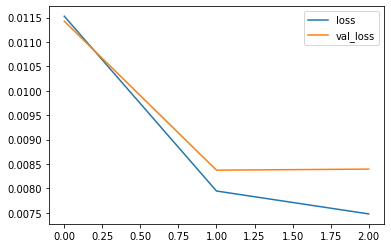

In [17]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [18]:
first_eval_batch = scaled_train[-length:]
first_eval_batch = first_eval_batch.reshape((1, length, scaled_train.shape[1]))

In [19]:
n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [20]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions = pd.DataFrame(data=true_predictions,columns=test.columns)

In [21]:
from tensorflow.keras.models import load_model
model.save("multivariate.h5")

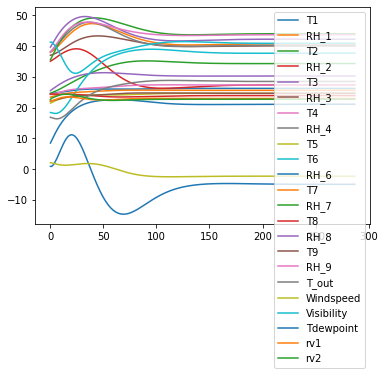

In [30]:
df_pred = true_predictions.drop(columns=['lights','Appliances','Press_mm_hg','RH_5','RH_out'])
df_pred.plot()